# Experiment 04

This Experiment is the main experiment of the work, consists in run an optimized Random Forest in order to try to predict the values in question.(https://www.researchgate.net/publication/221533996_From_an_artificial_neural_network_to_a_stock_market_day-trading_system_A_case_study_on_the_BMF_BOVESPA).

This method consists in using the sliding window 

In [67]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

### Constants and Parameters

In [68]:
dfColumns = ['date','open', 'high', 'low','close','volume']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']

top10_petr4 = ['LB_low', 'd-1_high', 'LB_close', 'LB_open', 'EMA_high', 'd-1_low','EMA_low', 'd-1_close', 'EMA_close', 'open']
top5_petr4 = ['d-1_low','EMA_low', 'd-1_close', 'EMA_close', 'open']
top3_petr4 = ['d-1_close', 'EMA_close', 'open']

top10_vale3 = ['d-1_high', 'd-1_low', 'UB_high', 'UB_low', 'UB_close', 'EMA_low','UB_open', 'd-1_close', 'EMA_close', 'open']
top5_vale3 = ['EMA_low','UB_open', 'd-1_close', 'EMA_close', 'open']
top3_vale3 = ['d-1_close', 'EMA_close', 'open']

top10_btc = ['EMA_low','d-2_low','EMA_close','d-1_close','open','d-1_low','EMA_high','EMA_open','d-2_close','d-1_high']
top5_btc = ['EMA_low','d-2_low','EMA_close','d-1_close','open']
top3_btc = ['EMA_low','d-2_low','EMA_close']

DAYS = 5

In [69]:
TEST_BEGIN = '2021-06-01 00:00:00'
TEST_END = '2022-06-01 00:00:00'

WINDOW = 596
DRIFT = 10

TIMES = 1

def safeDate(df, begin, period):
    index = df[df['date'] == begin].index[0]
    
    newIndex = index - (period + 2)
    newDate = df[df.index == newIndex].date
    
    return newDate.iloc[0]

### Opening the dataset

In [70]:
df[df['date'] == '2021-06-01 00:00:00']

date   open   high    low  close
658  2021-06-01 00:00:00  11.07  11.19  10.91  11.02

In [71]:
df = pd.read_parquet('dfpetr_1D.parquet')
df.columns = dfColumns
df = removeColumns(df, ['volume'])

beginDate = safeDate(df, TEST_BEGIN, WINDOW)

df2 = pd.read_parquet('dfvale_D1.parquet')
df2.columns = dfColumns
df2 = removeColumns(df2, ['volume'])

df0 = pd.read_parquet('dfbtc_1d.parquet')
df0.columns = dfColumns
df0 = removeColumns(df0, ['volume'])

In [72]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
df2 = calculateEMA(df2,DAYS,newColumns)
df2 = calculateBB(df2,DAYS,newColumns)
df2 = addPreviousDays(df2,DAYS, newColumns)

#BTC
df0 = calculateEMA(df0,DAYS,newColumns)
df0 = calculateBB(df0,DAYS,newColumns)
df0 = addPreviousDays(df0,DAYS, newColumns)

In [73]:
initialDf_PETR4 = getPeriod(df, beginDate ,TEST_END, True)
initialDf_VALE3 = getPeriod(df2,beginDate,TEST_END, True)
initialDf_BTC = getPeriod(df0,beginDate,TEST_END, True)

In [74]:
initialDf_PETR4

date   open   high    low  close   EMA_open   EMA_high  \
0    2019-01-02 00:00:00   8.56   9.18   8.45   9.13   8.326741   8.682916   
1    2019-01-03 00:00:00   9.09   9.42   9.03   9.35   8.581161   8.928611   
2    2019-01-04 00:00:00   9.43   9.46   9.29   9.38   8.864107   9.105741   
3    2019-01-07 00:00:00   9.43   9.84   9.37   9.53   9.052738   9.350494   
4    2019-01-08 00:00:00   9.64   9.65   9.40   9.47   9.248492   9.450329   
..                   ...    ...    ...    ...    ...        ...        ...   
843  2022-05-26 00:00:00  18.59  18.91  18.55  18.66  18.304855  18.663889   
844  2022-05-27 00:00:00  18.67  18.67  17.75  17.77  18.426570  18.665926   
845  2022-05-30 00:00:00  17.91  17.93  16.91  17.41  18.254380  18.420617   
846  2022-05-31 00:00:00  17.66  17.78  17.31  17.46  18.056253  18.207078   
847  2022-06-01 00:00:00  17.36  17.61  17.33  17.43  17.824169  18.008052   

       EMA_low  EMA_close    UB_open  ...  d-3_low  d-3_close  d-4_open  \
0     8.232786   8.592569   8.800760  ...     7.75       8.23      7.90   
1     8.498524   8.845046   9.354116  ...     8.08       8.22      7.81   
2     8.762350   9.023364   9.766114  ...     8.38       8.61      8.17   
3     8.964900   9.192243   9.950361  ...     8.45       9.13      8.39   
4     9.109933   9.284828  10.076522  ...     9.03       9.35      8.56   
..         ...        ...        ...  ...      ...        ...       ...   
843  18.147624  18.471009  18.746578  ...    18.35      18.90     18.06   
844  18.015083  18.237339  18.860112  ...    17.83      18.35     18.37   
845  17.646722  17.961559  18.980000  ...    18.15      18.61     18.12   
846  17.534481  17.794373  19.131900  ...    18.55      18.66     18.41   
847  17.466321  17.672915  19.188252  ...    17.75      17.77     18.59   

     d-4_high  d-4_low  d-4_close  d-5_open  d-5_high  d-5_low  d-5_close  
0        8.11     7.84       7.95      8.23      8.24     7.88       7.93  
1        8.23     7.75       8.23      7.90      8.11     7.84       7.95  
2        8.34     8.08       8.22      7.81      8.23     7.75       8.23  
3        8.66     8.38       8.61      8.17      8.34     8.08       8.22  
4        9.18     8.45       9.13      8.39      8.66     8.38       8.61  
..        ...      ...        ...       ...       ...      ...        ...  
843     18.18    17.88      18.18     17.50     17.90    17.40      17.84  
844     18.96    18.35      18.90     18.06     18.18    17.88      18.18  
845     18.63    17.83      18.35     18.37     18.96    18.35      18.90  
846     18.74    18.15      18.61     18.12     18.63    17.83      18.35  
847     18.91    18.55      18.66     18.41     18.74    18.15      18.61  

[848 rows x 37 columns]

In [75]:
initialDf_VALE3

date   open   high    low  close   EMA_open   EMA_high  \
0    2019-01-02 00:00:00  50.67  51.35  49.84  51.18  50.507572  51.162945   
1    2019-01-03 00:00:00  51.09  51.09  48.45  49.02  50.701714  51.138630   
2    2019-01-04 00:00:00  49.80  52.42  49.80  52.06  50.401143  51.565753   
3    2019-01-07 00:00:00  52.52  53.60  51.82  52.15  51.107429  52.243835   
4    2019-01-08 00:00:00  52.08  52.70  51.66  52.60  51.431619  52.395890   
..                   ...    ...    ...    ...    ...        ...        ...   
843  2022-05-26 00:00:00  84.13  84.61  83.14  84.35  82.687502  83.741679   
844  2022-05-27 00:00:00  84.25  85.86  84.22  85.75  83.208335  84.447786   
845  2022-05-30 00:00:00  85.95  87.39  85.90  86.68  84.122223  85.428524   
846  2022-05-31 00:00:00  86.65  87.43  85.04  86.49  84.964815  86.095683   
847  2022-06-01 00:00:00  86.21  88.78  86.03  88.21  85.379877  86.990455   

       EMA_low  EMA_close    UB_open  ...  d-3_low  d-3_close  d-4_open  \
0    49.870431  50.802331  51.019153  ...    49.44      50.70     50.25   
1    49.396954  50.208221  51.405142  ...    49.30      49.47     50.79   
2    49.531303  50.825481  51.387822  ...    50.12      51.21     50.15   
3    50.294202  51.266987  52.964571  ...    49.84      51.18     50.12   
4    50.749468  51.711325  53.414815  ...    48.45      49.02     50.67   
..         ...        ...        ...  ...      ...        ...       ...   
843  81.892267  83.294527  85.131737  ...    81.98      83.05     81.90   
844  82.668178  84.113018  85.662846  ...    81.05      84.02     82.00   
845  83.745452  84.968679  86.945624  ...    83.41      84.39     81.86   
846  84.176968  85.475786  87.434098  ...    83.14      84.35     84.00   
847  84.794645  86.387191  87.772369  ...    84.22      85.75     84.13   

     d-4_high  d-4_low  d-4_close  d-5_open  d-5_high  d-5_low  d-5_close  
0       51.24    50.25      50.90     50.60     51.17    49.51      50.16  
1       50.79    49.44      50.70     50.25     51.24    50.25      50.90  
2       50.35    49.30      49.47     50.79     50.79    49.44      50.70  
3       51.21    50.12      51.21     50.15     50.35    49.30      49.47  
4       51.35    49.84      51.18     50.12     51.21    50.12      51.21  
..        ...      ...        ...       ...       ...      ...        ...  
843     82.45    80.60      81.44     77.76     80.38    77.46      79.80  
844     83.62    81.98      83.05     81.90     82.45    80.60      81.44  
845     84.07    81.05      84.02     82.00     83.62    81.98      83.05  
846     84.79    83.41      84.39     81.86     84.07    81.05      84.02  
847     84.61    83.14      84.35     84.00     84.79    83.41      84.39  

[848 rows x 37 columns]

#### Experimento 04: Utilizando Random Forest

In [76]:
def getTrainPeriod(df, begin, period):
    
    index = df[df['date'] == begin].index[0]
    index = index-1
    
    endDate = df[df.index == index].date
    beginDate = df[df.index == (index-period)].date
    
    return beginDate.iloc[0], endDate.iloc[0]
    

def exp04(df, stock, inputColumns = []):
    
    beginTrain, endTrain = getTrainPeriod(df,TEST_BEGIN, WINDOW)
    
    df_test_aux = getPeriod(df, TEST_BEGIN, TEST_END)
    
    indexBegin = df_test_aux.head(1).index[0]
    indexEnd = df_test_aux.tail(1).index[0]
    
    for i in range (indexBegin, indexEnd, DRIFT):
        
        df_test = df[(df.index >= i) & (df.index <= i+DRIFT-1)]
        df_train = df[(df.index >= i-WINDOW) & (df.index < i)]
    
        if(inputColumns == []):
            x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
            y_train = df_train[['high','low']]

            x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
            y_test = df_test[['high','low']]
        else:
            x_train = df_train[inputColumns]
            y_train = df_train[['high','low']]

            x_test = df_test[inputColumns]
            y_test = df_test[['high','low']]

        rf = RandomForestRegressor(n_estimators = 500)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        print('train: ' + df_train['date'].head(1).tolist()[0] + ' - ' + df_train['date'].tail(1).tolist()[0])
        print('_test: ' + df_test['date'].head(1).tolist()[0] + ' - ' + df_test['date'].tail(1).tolist()[0])
        #printResult(mape(y_test['high'],y_pred[:,0]), 'High')
        #printResult(mape(y_test['low'],y_pred[:,1]), 'Low')
        #print('###')
        
        if(i == indexBegin):     
            predDf = y_test.copy()
            predDf['high_pred'] = y_pred[:,0]
            predDf['low_pred'] = y_pred[:,1]
        
        else:
            auxDf = y_test.copy()
            auxDf['high_pred'] = y_pred[:,0]
            auxDf['low_pred'] = y_pred[:,1]
            predDf = predDf.append(auxDf)
        
        #errorMax = mape(predDf['high'],predDf['high_pred'])
        #errorMin = mape(predDf['low'],predDf['low_pred'])
    
    return predDf

def test30timesExp04(df,stock, phrase, columnInput = []):

    acc_predDf = pd.DataFrame()
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            predDf = exp04(df, stock)
        else: 
            predDf = exp04(df, stock, columnInput)
        
        acc_predDf = acc_predDf.append(predDf)
        
    print(phrase)
    printResult(mape(acc_predDf['high'],acc_predDf['high_pred']), 'High')
    printResult(mape(acc_predDf['low'],acc_predDf['low_pred']), 'Low')
    
    return acc_predDf

In [78]:
exec01 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 3 Variables', top3_petr4)
exec02 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 5 Variables', top5_petr4) 
exec03 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 10 Variables', top10_petr4) 
exec04 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
exec05 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
exec06 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
exec07 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 3 Variables', top3_vale3)
exec08 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 5 Variables', top5_vale3) 
exec09 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 10 Variables', top10_vale3)
exec10 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15)
exec11 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25)
exec12 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')
print('\n')
exec13 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 3 Variables', top3_btc)
exec14 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 5 Variables', top5_btc) 
exec15 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 10 Variables', top10_btc)
exec16 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 15 Variables', col15)
exec17 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 25 Variables', col25)
exec18 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 33 Variables')

train: 2019-01-04 00:00:00 - 2021-05-31 00:00:00
_test: 2021-06-01 00:00:00 - 2021-06-15 00:00:00
train: 2019-01-18 00:00:00 - 2021-06-15 00:00:00
_test: 2021-06-16 00:00:00 - 2021-06-29 00:00:00
train: 2019-02-04 00:00:00 - 2021-06-29 00:00:00
_test: 2021-06-30 00:00:00 - 2021-07-14 00:00:00
train: 2019-02-18 00:00:00 - 2021-07-14 00:00:00
_test: 2021-07-15 00:00:00 - 2021-07-28 00:00:00
train: 2019-03-06 00:00:00 - 2021-07-28 00:00:00
_test: 2021-07-29 00:00:00 - 2021-08-11 00:00:00
train: 2019-03-20 00:00:00 - 2021-08-11 00:00:00
_test: 2021-08-12 00:00:00 - 2021-08-25 00:00:00
train: 2019-04-03 00:00:00 - 2021-08-25 00:00:00
_test: 2021-08-26 00:00:00 - 2021-09-09 00:00:00
train: 2019-04-17 00:00:00 - 2021-09-09 00:00:00
_test: 2021-09-10 00:00:00 - 2021-09-23 00:00:00
train: 2019-05-03 00:00:00 - 2021-09-23 00:00:00
_test: 2021-09-24 00:00:00 - 2021-10-07 00:00:00
train: 2019-05-17 00:00:00 - 2021-10-07 00:00:00
_test: 2021-10-08 00:00:00 - 2021-10-22 00:00:00
train: 2019-05-31 00

In [79]:
DRIFT = 2
exec19 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 3 Variables', top3_vale3)
exec20 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 5 Variables', top5_vale3) 
exec21 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 TOP 10 Variables', top10_vale3)
exec22 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15)
exec23 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25)
exec24 = test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')

train: 2019-01-04 00:00:00 - 2021-05-31 00:00:00
_test: 2021-06-01 00:00:00 - 2021-06-02 00:00:00
train: 2019-01-08 00:00:00 - 2021-06-02 00:00:00
_test: 2021-06-04 00:00:00 - 2021-06-07 00:00:00
train: 2019-01-10 00:00:00 - 2021-06-07 00:00:00
_test: 2021-06-08 00:00:00 - 2021-06-09 00:00:00
train: 2019-01-14 00:00:00 - 2021-06-09 00:00:00
_test: 2021-06-10 00:00:00 - 2021-06-11 00:00:00
train: 2019-01-16 00:00:00 - 2021-06-11 00:00:00
_test: 2021-06-14 00:00:00 - 2021-06-15 00:00:00
train: 2019-01-18 00:00:00 - 2021-06-15 00:00:00
_test: 2021-06-16 00:00:00 - 2021-06-17 00:00:00
train: 2019-01-22 00:00:00 - 2021-06-17 00:00:00
_test: 2021-06-18 00:00:00 - 2021-06-21 00:00:00
train: 2019-01-24 00:00:00 - 2021-06-21 00:00:00
_test: 2021-06-22 00:00:00 - 2021-06-23 00:00:00
train: 2019-01-29 00:00:00 - 2021-06-23 00:00:00
_test: 2021-06-24 00:00:00 - 2021-06-25 00:00:00
train: 2019-01-31 00:00:00 - 2021-06-25 00:00:00
_test: 2021-06-28 00:00:00 - 2021-06-29 00:00:00
train: 2019-02-04 00

In [80]:
DRIFT = 5
exec25 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 3 Variables', top3_petr4)
exec26 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 5 Variables', top5_petr4) 
exec27 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 TOP 10 Variables', top10_petr4) 
exec28 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
exec29 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
exec30 = test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')

train: 2019-01-04 00:00:00 - 2021-05-31 00:00:00
_test: 2021-06-01 00:00:00 - 2021-06-08 00:00:00
train: 2019-01-11 00:00:00 - 2021-06-08 00:00:00
_test: 2021-06-09 00:00:00 - 2021-06-15 00:00:00
train: 2019-01-18 00:00:00 - 2021-06-15 00:00:00
_test: 2021-06-16 00:00:00 - 2021-06-22 00:00:00
train: 2019-01-28 00:00:00 - 2021-06-22 00:00:00
_test: 2021-06-23 00:00:00 - 2021-06-29 00:00:00
train: 2019-02-04 00:00:00 - 2021-06-29 00:00:00
_test: 2021-06-30 00:00:00 - 2021-07-06 00:00:00
train: 2019-02-11 00:00:00 - 2021-07-06 00:00:00
_test: 2021-07-07 00:00:00 - 2021-07-14 00:00:00
train: 2019-02-18 00:00:00 - 2021-07-14 00:00:00
_test: 2021-07-15 00:00:00 - 2021-07-21 00:00:00
train: 2019-02-25 00:00:00 - 2021-07-21 00:00:00
_test: 2021-07-22 00:00:00 - 2021-07-28 00:00:00
train: 2019-03-06 00:00:00 - 2021-07-28 00:00:00
_test: 2021-07-29 00:00:00 - 2021-08-04 00:00:00
train: 2019-03-13 00:00:00 - 2021-08-04 00:00:00
_test: 2021-08-05 00:00:00 - 2021-08-11 00:00:00
train: 2019-03-20 00

In [81]:
DRIFT = 7

exec31 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 3 Variables', top3_btc)
exec32 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 5 Variables', top5_btc) 
exec33 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT TOP 10 Variables', top10_btc)
exec34 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 15 Variables', col15)
exec35 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 25 Variables', col25)
exec36 = test30timesExp04(initialDf_BTC, 'BTCUSDT', 'BTCUSDT 33 Variables')

train: 2019-10-14 00:00:00 - 2021-05-31 00:00:00
_test: 2021-06-01 00:00:00 - 2021-06-07 00:00:00
train: 2019-10-21 00:00:00 - 2021-06-07 00:00:00
_test: 2021-06-08 00:00:00 - 2021-06-14 00:00:00
train: 2019-10-28 00:00:00 - 2021-06-14 00:00:00
_test: 2021-06-15 00:00:00 - 2021-06-21 00:00:00
train: 2019-11-04 00:00:00 - 2021-06-21 00:00:00
_test: 2021-06-22 00:00:00 - 2021-06-28 00:00:00
train: 2019-11-11 00:00:00 - 2021-06-28 00:00:00
_test: 2021-06-29 00:00:00 - 2021-07-05 00:00:00
train: 2019-11-18 00:00:00 - 2021-07-05 00:00:00
_test: 2021-07-06 00:00:00 - 2021-07-12 00:00:00
train: 2019-11-25 00:00:00 - 2021-07-12 00:00:00
_test: 2021-07-13 00:00:00 - 2021-07-19 00:00:00
train: 2019-12-02 00:00:00 - 2021-07-19 00:00:00
_test: 2021-07-20 00:00:00 - 2021-07-26 00:00:00
train: 2019-12-09 00:00:00 - 2021-07-26 00:00:00
_test: 2021-07-27 00:00:00 - 2021-08-02 00:00:00
train: 2019-12-16 00:00:00 - 2021-08-02 00:00:00
_test: 2021-08-03 00:00:00 - 2021-08-09 00:00:00
train: 2019-12-23 00

In [82]:
predDf_petr4 = exec27
predDf_vale3 = exec21
predDf_btc = exec33
predDf_petr4['date'] = getPeriod(initialDf_PETR4, TEST_BEGIN, TEST_END)['date']
predDf_vale3['date'] = getPeriod(initialDf_VALE3, TEST_BEGIN, TEST_END)['date']
predDf_btc['date'] = getPeriod(initialDf_BTC, TEST_BEGIN, TEST_END)['date']

display(predDf_petr4.head(10))
predDf_petr4.to_pickle('PETR4_Pred_ytd_RF.pkl')
display(predDf_vale3.head(10))
predDf_vale3.to_pickle('VALE3_Pred_ytd_RF.pkl')
display(predDf_btc.head(10))
predDf_btc.to_pickle('BTC_Pred_ytd_RF.pkl')

high    low  high_pred  low_pred                 date
598  11.19  10.91   11.16546  10.96390  2021-06-01 00:00:00
599  11.34  11.01   11.18996  10.96716  2021-06-02 00:00:00
600  11.56  11.28   11.57476  11.08674  2021-06-04 00:00:00
601  11.53  11.31   11.69486  11.19242  2021-06-07 00:00:00
602  11.63  11.29   11.49966  11.19422  2021-06-08 00:00:00
603  11.75  11.52   11.76044  11.46982  2021-06-09 00:00:00
604  11.73  11.54   11.72062  11.48014  2021-06-10 00:00:00
605  11.65  11.42   11.71492  11.49930  2021-06-11 00:00:00
606  11.86  11.56   11.73278  11.51052  2021-06-14 00:00:00
607  11.74  11.56   11.72236  11.51074  2021-06-15 00:00:00

high     low  high_pred   low_pred                 date
598  117.99  113.65  115.75572  112.96552  2021-06-01 00:00:00
599  115.67  113.50  115.84500  112.61140  2021-06-02 00:00:00
600  114.78  112.45  116.24142  113.49028  2021-06-04 00:00:00
601  112.65  110.73  113.86300  110.78844  2021-06-07 00:00:00
602  112.80  109.72  113.70580  111.06930  2021-06-08 00:00:00
603  113.33  109.14  111.71838  108.50344  2021-06-09 00:00:00
604  113.34  111.10  113.03246  110.55662  2021-06-10 00:00:00
605  114.75  112.50  113.28806  110.58060  2021-06-11 00:00:00
606  115.26  113.13  115.25492  112.88946  2021-06-14 00:00:00
607  114.49  111.33  115.20516  112.89634  2021-06-15 00:00:00

high       low    high_pred     low_pred                 date
881  37894.81  35666.00  38592.92150  35747.45848  2021-06-01 00:00:00
882  38225.00  35920.00  38102.85176  35399.94182  2021-06-02 00:00:00
883  39476.00  37170.00  39338.22656  35939.62812  2021-06-03 00:00:00
884  39289.07  35555.15  40268.02748  36773.99178  2021-06-04 00:00:00
885  37925.00  34800.00  38501.64210  35504.32606  2021-06-05 00:00:00
886  36480.00  35222.00  37299.90618  34122.09090  2021-06-06 00:00:00
887  36900.00  33300.00  37103.91940  34219.29404  2021-06-07 00:00:00
888  34068.01  31000.00  37012.22914  33331.64896  2021-06-08 00:00:00
889  37534.79  32396.82  37295.58118  33121.31888  2021-06-09 00:00:00
890  38491.00  35782.00  39241.72720  35760.26202  2021-06-10 00:00:00

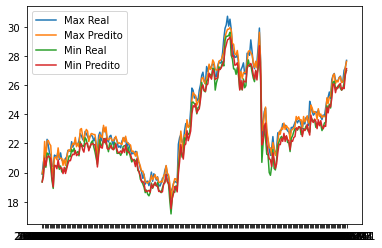

In [ ]:
plottingdf = predDf_petr4
plt.plot(plottingdf['date'], plottingdf['high'], label = "Max Real")
plt.plot(plottingdf['date'], plottingdf['high_pred'], label = "Max Predito")
plt.plot(plottingdf['date'], plottingdf['low'], label = "Min Real")
plt.plot(plottingdf['date'], plottingdf['low_pred'], label = "Min Predito")
plt.legend()
plt.show()

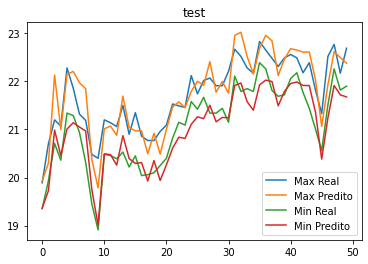

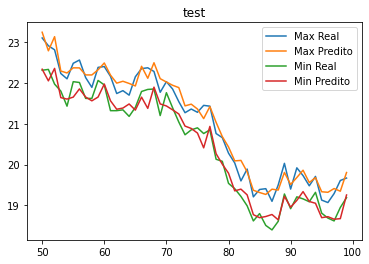

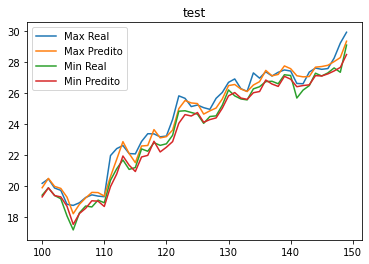

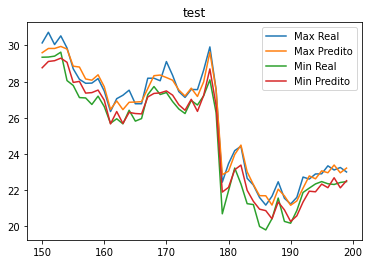

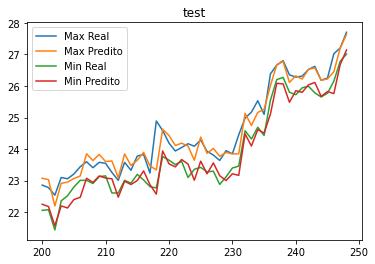

In [ ]:
dfs = {}
chunk = 50

df = plottingdf.reset_index()

for n in range((df.shape[0] // chunk + 1)):
    df_temp = df.iloc[n*chunk:(n+1)*chunk]
    #df_temp = df_temp.reset_index(drop=True)
    dfs[n] = df_temp

if df.shape[0] % chunk != 0:
    df_temp = df.iloc[-int(df.shape[0] % chunk):]
    #df_temp = df_temp.reset_index(drop=True)
    dfs[n] = df_temp
else:
    pass

for i in range(0,len(dfs)):
    plt.plot(dfs[i].index, dfs[i]['high'], label = "Max Real")
    plt.plot(dfs[i].index, dfs[i]['high_pred'], label = "Max Predito")
    plt.plot(dfs[i].index, dfs[i]['low'], label = "Min Real")
    plt.plot(dfs[i].index, dfs[i]['low_pred'], label = "Min Predito")
    plt.legend()
    plt.show()
    plt.clf